In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
import numpy as np

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

import graspy as gp
from graspy.plot import heatmap

In [2]:
def plot_heatmap(graph, labels, title):
    cmap = mpl.cm.get_cmap('binary')
#     center = 0
#     vmin = 0
#     vmax = 1
#     norm = mpl.colors.Normalize(0, 1)
#     cc = np.linspace(0.5, 1, 256)
#     cmap = mpl.colors.ListedColormap(cmap(cc))

    heatmap_kws = dict(
        cbar=False,
        font_scale=1.4,
        vmin=0,
        vmax=1,
        inner_hier_labels=labels,
        hier_label_fontsize=20,
        cmap=cmap,
        center=None,
    )
    side_label_kws = dict(labelpad=45, fontsize=24)

    fig, ax = plt.subplots(1, 1, figsize=(20, 16))

    # SBM
    heatmap(graph, ax=ax, **heatmap_kws)
    ax.set_title(title, pad = 100, fontdict = {'fontsize' : 23})

    # Add colorbar
#     sm = plt.cm.ScalarMappable(cmap=cmap)
#     sm.set_array(data)
#     cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
#     cbar.ax.tick_params(labelsize=16)

    plt.savefig(
        "adj_matrix.pdf",
        facecolor="w",
        format="pdf",
        bbox_inches="tight",
    )

    plt.tight_layout()
    plt.show()

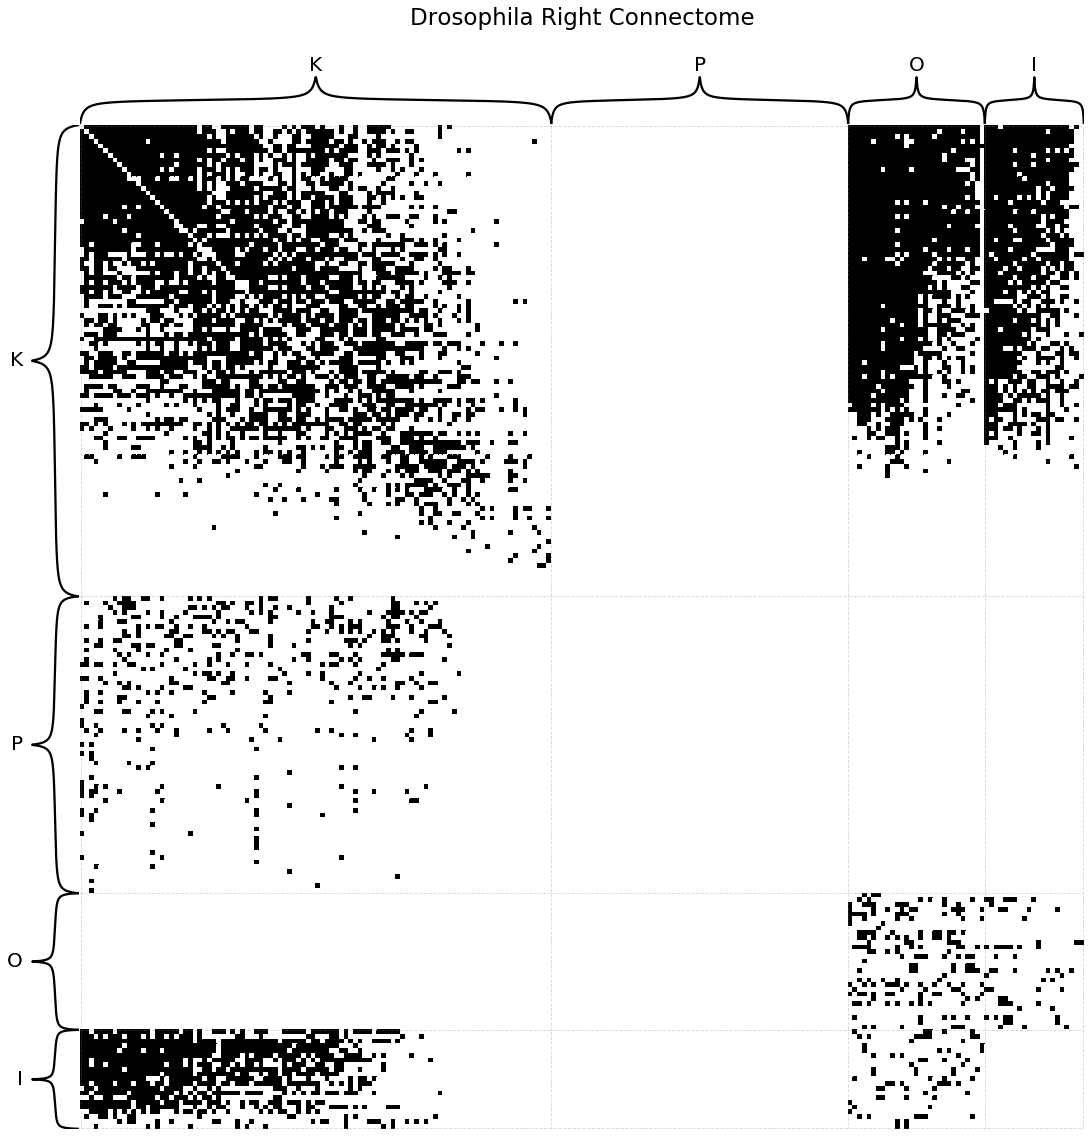

In [3]:
graph, labels = gp.datasets.load_drosophila_right(return_labels=True)

plot_heatmap(graph, labels, "Drosophila Right Connectome")

In [4]:
# Neuronal features and label.
data = pd.read_csv("vdf.csv")
print(data)

                                                    v type  claw        dist  \
0    Thermo KC A_Right - Mushroom Body  Left #4229950   KC   2.0   337.63801   
1                                       KC12 #4230061   KC   1.0     0.00000   
2                                       KC10 #4227304   KC   1.0  1291.20357   
3                                       KC42 #8066542   KC   1.0   252.63347   
4                                       KC16 #4415241   KC   2.0  1822.29525   
..                                                ...  ...   ...         ...   
208                                        mPN D left   PN   NaN         NaN   
209                                    mPN iACT VUM L   PN   NaN         NaN   
210      1+2 #1 MB PN - putative - double check again   PN   NaN         NaN   
211                                   mPN cobra right   PN   NaN         NaN   
212         Upper Looping PN Right - AVM004 (BAla1/2)   PN   NaN         NaN   

        age  cluster  
0    mature     

In [5]:
# Preprocess
labels = data.type.to_list()
unique_labels = np.unique(labels)

data.age = pd.factorize(data.age)[0]
data.v = pd.factorize(data.v)[0]
data = data.fillna(0)
print(data)

       v type  claw        dist  age  cluster
0      0   KC   2.0   337.63801    0        1
1      1   KC   1.0     0.00000    0        1
2      2   KC   1.0  1291.20357    0        1
3      3   KC   1.0   252.63347    0        1
4      4   KC   2.0  1822.29525    0        1
..   ...  ...   ...         ...  ...      ...
208  208   PN   0.0     0.00000   -1        6
209  209   PN   0.0     0.00000   -1        6
210  210   PN   0.0     0.00000   -1        6
211  211   PN   0.0     0.00000   -1        6
212  212   PN   0.0     0.00000   -1        6

[213 rows x 6 columns]


In [6]:
col_names = ["claw", "dist", "age", "cluster"]
X = np.array(data[col_names])
y = np.array(pd.factorize(data.type)[0])
print(X.shape)
print(y.shape)

(213, 4)
(213,)


In [7]:

  
'''
Primary Author: Will LeVine
Email: levinewill@icloud.com
'''

#Model
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Infrastructure
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import NotFittedError

#Data Handling
from sklearn.utils.validation import (
    check_X_y,
    check_array,
    NotFittedError,
)
from sklearn.utils.multiclass import check_classification_targets

#Utils
from joblib import Parallel, delayed
import numpy as np

def _finite_sample_correction(posteriors, num_points_in_partition, num_classes):
    '''
    encourage posteriors to approach uniform when there is low data
    '''
    correction_constant = 1 / (num_classes * num_points_in_partition)

    zero_posterior_idxs = np.where(posteriors == 0)[0]
    posteriors[zero_posterior_idxs] = correction_constant
    
    posteriors /= sum(posteriors)
    
    return posteriors

class UncertaintyForest_New(BaseEstimator, ClassifierMixin):
    '''
    based off of https://arxiv.org/pdf/1907.00325.pdf
    '''
    def __init__(
        self,
        max_depth=30,
        min_samples_leaf=1,
        max_samples = 0.63,
        max_features_tree = "auto",
        n_estimators=100,
        bootstrap=False,
        parallel=True,
        n_jobs = None):

        #Tree parameters.
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features_tree = max_features_tree

        #Bag parameters
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.max_samples = max_samples

        #Model parameters.
        self.parallel = parallel
        if self.parallel and n_jobs == None:
            self.n_jobs = self.n_estimators
        else:
            self.n_jobs = n_jobs
        self.fitted = False

    def _check_fit(self):
        '''
        raise a NotFittedError if the model isn't fit
        '''
        if not self.fitted:
                msg = (
                        "This %(name)s instance is not fitted yet. Call 'fit' with "
                        "appropriate arguments before using this estimator."
                )
                raise NotFittedError(msg % {"name": type(self).__name__})

    def transform(self, X):
        '''
        get the estimated posteriors across trees
        '''
        X = check_array(X)
                
        def worker(tree_idx, tree):
            #get the nodes of X
            # Drop each estimation example down the tree, and record its 'y' value.
            return tree.apply(X)
            

        if self.parallel:
            return np.array(
                    Parallel(n_jobs=self.n_jobs)(
                            delayed(worker)(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)
                    )
            )         
        else:
            return np.array(
                    [worker(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)]
                    )
        
    def get_transformer(self):
        return lambda X : self.transform(X)
        
    def vote(self, nodes_across_trees):
        return self.voter.predict(nodes_across_trees)
        
    def get_voter(self):
        return self.voter
        
                        
    def fit(self, X, y):

        #format X and y
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        
        #define the ensemble
        self.ensemble = BaggingClassifier(
            DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features_tree
            ),
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,
            bootstrap=self.bootstrap,
            n_jobs = self.n_jobs
        )
        
        #fit the ensemble
        self.ensemble.fit(X, y)
        
        class Voter(BaseEstimator):
            def __init__(self, estimators_samples_, classes, parallel, n_jobs):
                self.n_estimators = len(estimators_samples_)
                self.classes_ = classes
                self.parallel = parallel
                self.estimators_samples_ = estimators_samples_
                self.n_jobs = n_jobs
            
            def fit(self, nodes_across_trees, y, fitting = False):
                self.tree_idx_to_node_ids_to_posterior_map = {}

                def worker(tree_idx):
                    nodes = nodes_across_trees[tree_idx]
                    oob_samples = np.delete(range(len(nodes)), self.estimators_samples_[tree_idx])
                    cal_nodes = nodes[oob_samples] if fitting else nodes
                    y_cal = y[oob_samples] if fitting else y                    
                    
                    #create a map from the unique node ids to their classwise posteriors
                    node_ids_to_posterior_map = {}

                    #fill in the posteriors 
                    for node_id in np.unique(cal_nodes):
                        cal_idxs_of_node_id = np.where(cal_nodes == node_id)[0]
                        cal_ys_of_node = y_cal[cal_idxs_of_node_id]
                        class_counts = [len(np.where(cal_ys_of_node == y)[0]) for y in np.unique(y) ]
                        posteriors = np.nan_to_num(np.array(class_counts) / np.sum(class_counts))

                        #finite sample correction
                        posteriors_corrected = _finite_sample_correction(posteriors, len(cal_idxs_of_node_id), len(self.classes_))
                        node_ids_to_posterior_map[node_id] = posteriors_corrected

                    #add the node_ids_to_posterior_map to the overall tree_idx map 
                    self.tree_idx_to_node_ids_to_posterior_map[tree_idx] = node_ids_to_posterior_map
                    
                for tree_idx in range(self.n_estimators):
                        worker(tree_idx)
                return self
                        
                        
            def predict_proba(self, nodes_across_trees):
                def worker(tree_idx):
                    #get the node_ids_to_posterior_map for this tree
                    node_ids_to_posterior_map = self.tree_idx_to_node_ids_to_posterior_map[tree_idx]

                    #get the nodes of X
                    nodes = nodes_across_trees[tree_idx]

                    posteriors = []
                    node_ids = node_ids_to_posterior_map.keys()

                    #loop over nodes of X
                    for node in nodes:
                        #if we've seen this node before, simply get the posterior
                        if node in node_ids:
                            posteriors.append(node_ids_to_posterior_map[node])
                        #if we haven't seen this node before, simply use the uniform posterior 
                        else:
                            posteriors.append(np.ones((len(np.unique(self.classes_)))) / len(self.classes_))
                    return posteriors

                if self.parallel:
                    return np.mean(
                            Parallel(n_jobs=self.n_jobs)(
                                    delayed(worker)(tree_idx) for tree_idx in range(self.n_estimators)
                            ), axis = 0
                    )

                else:
                    return np.mean(
                            [worker(tree_idx) for tree_idx in range(self.n_estimators)], axis = 0)
                
        #get the nodes of the calibration set
        nodes_across_trees = self.transform(X) 
        self.voter = Voter(estimators_samples_ = self.ensemble.estimators_samples_, classes = self.classes_, parallel = self.parallel, n_jobs = self.n_jobs)
        self.voter.fit(nodes_across_trees, y, fitting = True)
        self.fitted = True

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=-1)]

    def predict_proba(self, X):
        return self.voter.predict_proba(self.transform(X))



In [76]:
class UncertaintyForest:
    def __init__(self, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.base = base
        self.kappa = kappa
        self.classes_ = None
        
    def fit(self, X, y):
        self.classes_, y = np.unique(y, return_inverse=True)
                
        # Build forest with default parameters.
        model = BaggingClassifier(DecisionTreeClassifier(), 
                                  n_estimators=self.n_estimators, 
                                  max_samples=self.max_samples, 
                                  bootstrap=False)
        model.fit(X, y)
        n = X.shape[0]
        K = model.n_classes_
        
        self.posteriors = []
        for tree_idx, tree in enumerate(model):

            # Find the indices of the training set used for partition.
            sampled_indices = model.estimators_samples_[tree_idx]
            vote_indices = np.delete(np.arange(0,n), sampled_indices)

            # Store the posterior in a num_nodes-by-num_classes matrix.
            # Posteriors in non-leaf cells will be zero everywhere
            # and later changed to uniform.
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            for vote_index in vote_indices:
                class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
            row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
            row_sums[row_sums == 0] = 1 # Avoid divide by zero.
            class_probs = class_counts / row_sums[:, None]

            # Make the nodes that have no estimation indices uniform.
            # This includes non-leaf nodes, but that will not affect the estimate.
            where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
            for elem in where_empty:
                class_probs[elem] = [1 / K]*K

            # Apply finite sample correction and renormalize.
            where_0 = np.argwhere(class_probs == 0)
            for elem in where_0:
                class_probs[elem[0], elem[1]] = 1 / (self.kappa*class_counts.sum(axis = 1)[elem[0]])
            row_sums = class_probs.sum(axis=1)
            class_probs = class_probs / row_sums[:, None]
            self.posteriors.append(class_probs)
            
        self.model = model
        return self
            
    def predict_proba(self, X):
    
        n = X.shape[0]
        K = self.model.n_classes_
        eval_posteriors = np.zeros((n, K))
        
        for tree_idx, tree in enumerate(self.model):
            # Place evaluation points in their corresponding leaf node.
            # Store evaluation posterior in a num_eval-by-num_class matrix.
            class_probs = self.posteriors[tree_idx]
            eval_posteriors += np.array([class_probs[x] for x in tree.apply(X)])

        return eval_posteriors / self.n_estimators
    
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=-1)]

In [11]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

In [23]:
def select_positive_class(y, pos_label=0):
    new_labels = []
    for elem in y:
        if elem == pos_label:
            new_labels.append(1)
        else:
            new_labels.append(0)
    return np.array(new_labels)

In [96]:
y_0 = select_positive_class(y, 3)
print(y_0)
unique, counts = np.unique(y_0, return_counts=True)
print(counts)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[150  63]


In [98]:
import random 
indices = random.sample(range(0,150), 63)
print(indices)

[20, 108, 118, 29, 44, 21, 127, 148, 130, 31, 55, 87, 28, 97, 61, 114, 98, 129, 45, 60, 146, 149, 25, 119, 68, 10, 110, 102, 75, 40, 14, 32, 94, 123, 39, 54, 106, 36, 116, 35, 141, 107, 73, 2, 27, 62, 140, 58, 137, 66, 18, 101, 42, 67, 132, 63, 82, 77, 51, 1, 4, 95, 85]


In [99]:
indices.extend(range(150, 203))

In [103]:
y_balanced = y_0[indices]
X_balanced = X[indices]

In [104]:
print(X_balanced.shape)
print(y_balanced)

(116, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [45]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [33]:
def plot_calibration_curve(X, y, fig_index, name="Random Forest (CART)", est = RandomForestClassifier(n_estimators = 300), pos_label=3):
    # Get train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9,
                                                    random_state=42)
    
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    uf = UncertaintyForest_New(n_estimators=300, parallel=False)
    #uf = UncertaintyForest_New(n_estimators=300, parallel=False)

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(20, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (uf, "Uncertainty Forest")]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, pos_label]
        else:  # use decision function
            print("used here")
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
        y_test_binary = select_positive_class(y_test, pos_label=pos_label)
        y_pred_binary = select_positive_class(y_pred, pos_label=pos_label)
        clf_score = brier_score_loss(y_test_binary, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test_binary, y_pred_binary))
        print("\tRecall: %1.3f" % recall_score(y_test_binary, y_pred_binary))
        print("\tF1: %1.3f\n" % f1_score(y_test_binary, y_pred_binary))
        
        
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test_binary, prob_pos, n_bins=100)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        count, bins = np.histogram(prob_pos, range=(0, 1), bins=10)
        print(count)
        print(bins)
        ax2.scatter(bins[1:], count, label=name)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.savefig("calibration_plots_pos_label_3.pdf")

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic:
	Brier: 0.108
	Precision: 0.580
	Recall: 1.000
	F1: 0.734

[80  6  2 19 85  0  0  0  0  0]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Random Forest (CART):
	Brier: 0.306
	Precision: 1.000
	Recall: 1.000
	F1: 1.000

[106  26   0   1   1   0   0   0   0  58]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Random Forest (CART) + Isotonic:
	Brier: 0.263
	Precision: 0.983
	Recall: 1.000
	F1: 0.991

[132   1   0   0   0   0   1   0   0  58]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Uncertainty Forest:
	Brier: 0.131
	Precision: 1.000
	Recall: 1.000
	F1: 1.000

[89 17 27  1  0  0 58  0  0  0]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


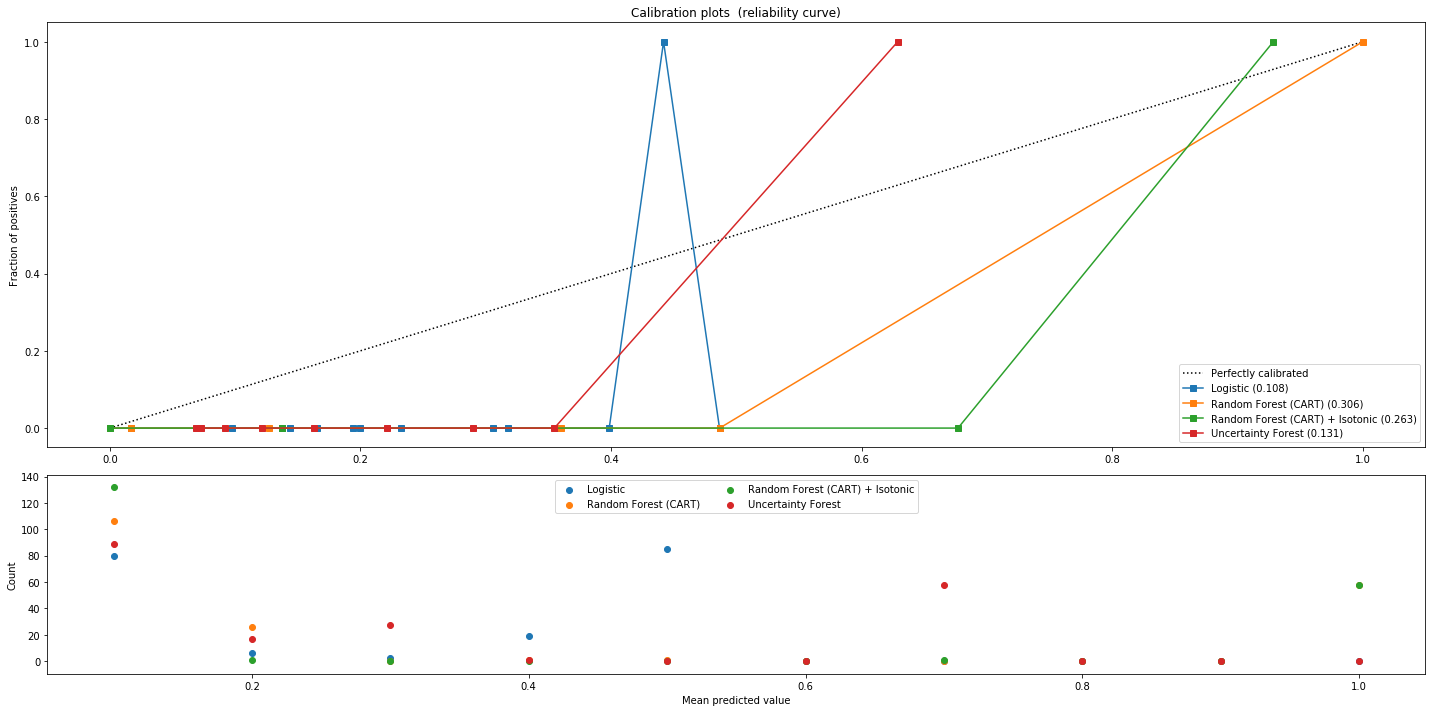

In [34]:
plot_calibration_curve(X, y, fig_index=1)


## Testing on known simulated data

In [77]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

X, y = generate_data(5000, 1, 1)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic:
	Brier: 0.109
	Precision: 0.857
	Recall: 0.842
	F1: 0.850

Random Forest (CART):
	Brier: 0.156
	Precision: 0.794
	Recall: 0.786
	F1: 0.790

Random Forest (CART) + Isotonic:
	Brier: 0.126
	Precision: 0.846
	Recall: 0.834
	F1: 0.840

Uncertainty Forest:
	Brier: 0.122
	Precision: 0.836
	Recall: 0.859
	F1: 0.848



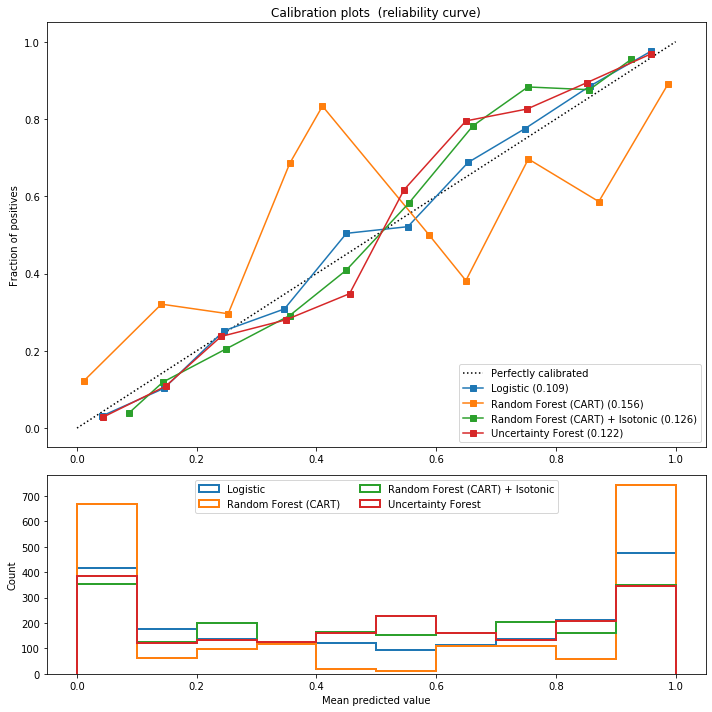

In [89]:
plot_calibration_curve(X, y, fig_index=1)
